In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Introduction

- Wine quality highly depends on its composition of various aromatic compounds. By assessing the content of wines such as their sugar content and pH value, we will be able to determine how good the wine is. 
- In this project, we will be using the wine quality dataset obtained from a web URL.
- We want to solve **classification problem** —- what would be the wine’s quality level given its values on the fixed acidity, volatile acidity, and other variables.
-  7 out of the 12 variables are used to predict the **wine quality**, which ranges from 0 to 10, with 10 being the highest quality wine.


## Preliminary exploratory data analysis

**1. Data Reading**

In [2]:
temp <- tempfile()
download_file <- download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", temp)
red_wine <- read.csv2(unz(temp, "winequality-red.csv")) |>
             mutate(type = "Red")
white_wine <- read.csv2(unz(temp, "winequality-white.csv")) |>
              mutate(type ="White")
head(red_wine)
head(white_wine)
unlink(temp)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
2,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,Red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,Red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,Red
5,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
6,7.4,0.66,0,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,White
2,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,White
3,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,White
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,White
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,White
6,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,White


**2. Data Wrangling**

In [3]:
wine_data <- rbind(red_wine, white_wine) |>
             mutate(across(fixed.acidity:alcohol, as.numeric), quality = as_factor(quality),
                   type = as_factor(type))
write_csv(wine_data, "../data/wine_data.csv")
head(wine_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,Red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,Red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,Red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


In [4]:
wine_data <- wine_data |>
    select(fixed.acidity:quality) |>
    mutate(quality = fct_recode(quality, "Low" = "3",
                                "Low" = "4",
                                "Low" = "5",
                                "High" = "6",
                                "High" = "7",
                                "High" = "8",
                                "High" = "9"))
head(wine_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,Low
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,Low
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,Low
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,High
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,Low
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,Low


**3. Data Splitting**

In [6]:
set.seed(2000)
wine_unscaled_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_unscaled_training <- training(wine_unscaled_split)
wine_unscaled_testing <- testing(wine_unscaled_split)

**4. Summarization**

**a. The number of observations in each Low quality & High quality wine class**

In [7]:
wine_type_number <- wine_unscaled_training |>
                    group_by(quality) |>
                    summarize(Number = n())
wine_type_number

quality,Number
<fct>,<int>
Low,1788
High,3084


- We have 1788 observations for Low-quality wine and 3084 observations for Red wine.
- There is an imbalance between the quality of the wine.
- So we need to balance the data.

**b. The mean value of each measurements for different quality types**

In [8]:
unscaled_mean_measurements <- wine_unscaled_training |>
                     group_by(quality) |>
                     summarize(mean_fixed_acidity = mean(fixed.acidity),
                               mean_volatile_acidity = mean(volatile.acidity),
                               mean_citric_acid = mean(citric.acid),
                               mean_residual_sugar = mean(residual.sugar),
                               mean_chlorides = mean(chlorides),
                               mean_free_sufdioxide = mean(free.sulfur.dioxide),
                               mean_tot_sufdioxide = mean(total.sulfur.dioxide),
                               mean_density = mean(density),
                               mean_ph = mean(pH),
                               mean_sulphates = mean(sulphates),
                               mean_alcohol = mean(alcohol))
unscaled_mean_measurements

quality,mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_sufdioxide,mean_tot_sufdioxide,mean_density,mean_ph,mean_sulphates,mean_alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low,7.355369,0.3994239,0.3020582,5.567450,0.06405481,28.94267,117.7634,0.9957594,3.212964,0.5225783,9.867271
High,7.153810,0.3051832,0.3271206,5.363521,0.05077140,31.11787,113.7327,0.9941084,3.221112,0.5361252,10.847424


- The ranges of the mean are different across different columns hence the variables will need to be scaled.

**c. We do the scaling, centering, and balancing.**

In [10]:
wine_recipe <- recipe(quality ~ ., wine_unscaled_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(quality, over_ratio = 1, skip = FALSE) |>
    prep()
scaled_wine <- bake(wine_recipe, wine_unscaled_training)
head(scaled_wine)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.5124886,0.06169715,-0.74634230,-0.7378432,0.5136953,0.89991794,-0.2345506,0.5543115,0.3262126,0.3321497,-0.8290611,Low
0.2837735,-0.33028308,0.01436475,1.9104467,0.2176796,0.09644124,1.5229912,1.0804441,-1.3715644,-0.5518335,-1.0808735,Low
-0.1736566,0.06169715,-0.05479044,-0.7586959,0.3952890,-0.87920905,0.8306263,-0.1033542,-0.2397131,-0.4158361,-0.9129985,Low
0.4362502,1.81053205,-2.19860121,-0.7378432,0.4840937,-0.19051473,-1.0689392,0.4885449,0.5777352,0.6721432,0.4300009,Low
0.3600118,0.30291576,-1.36873898,-0.7795485,1.2241328,-0.64964427,-1.5660217,0.4096250,-0.3654743,-0.2798387,-0.9129985,Low
-0.5548484,-0.48104471,1.25915810,0.5341701,-0.1375391,0.89991794,1.4519794,0.2123253,-0.2397131,-0.4158361,-0.8290611,Low


**d. The Observation Number of each quality type after balancing**

In [12]:
balanced_num <- scaled_wine |>
    group_by(quality) |>
    summarize(number = n())
balanced_num

quality,number
<fct>,<int>
Low,3084
High,3084


Now the number of observations for both Low quality wine and High quality wine are both 3084.

**e. Mean value of each measurements for different quality type.**

In [13]:
mean_measurements <- scaled_wine |>
                     group_by(quality) |>
                     summarize(mean_fixed_acidity = mean(fixed.acidity),
                               mean_volatile_acidity = mean(volatile.acidity),
                               mean_citric_acid = mean(citric.acid),
                               mean_residual_sugar = mean(residual.sugar),
                               mean_chlorides = mean(chlorides),
                               mean_free_sufdioxide = mean(free.sulfur.dioxide),
                               mean_tot_sufdioxide = mean(total.sulfur.dioxide),
                               mean_density = mean(density),
                               mean_ph = mean(pH),
                               mean_sulphates = mean(sulphates),
                               mean_alcohol = mean(alcohol))
mean_measurements

quality,mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_sufdioxide,mean_tot_sufdioxide,mean_density,mean_ph,mean_sulphates,mean_alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low,0.12545036,0.3749431,-0.10082662,0.02777932,0.285291,-0.07575095,0.04283343,0.3667547,-0.03068184,-0.04343073,-0.5167369
High,-0.05639444,-0.2085690,0.06360755,-0.01560628,-0.144306,0.04581454,-0.02626145,-0.1992462,0.01880301,0.03380645,0.3019328


After scaling and centering, we can determine which variable we are going to select for predictor.
According to the dataframe above, mean_alcohol shows the greatest difference among low and high quality wine, so we choose Alcohol as our predictor.

**f. Missing data - We have no missing data in this dataset.**

**4. Visualization: histogram between quality and other numeric variables**

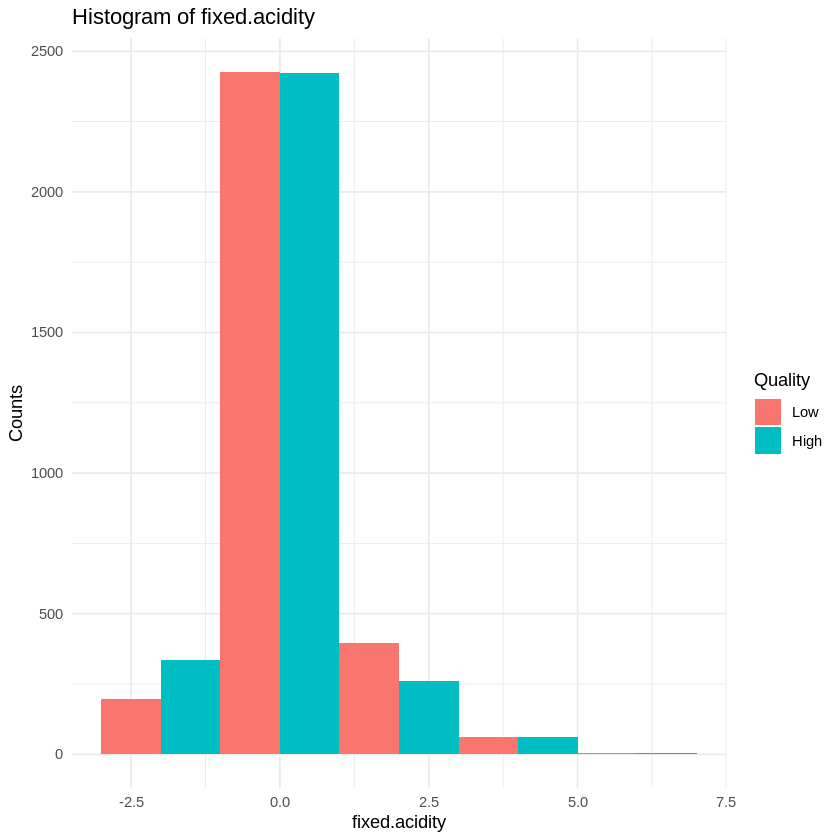

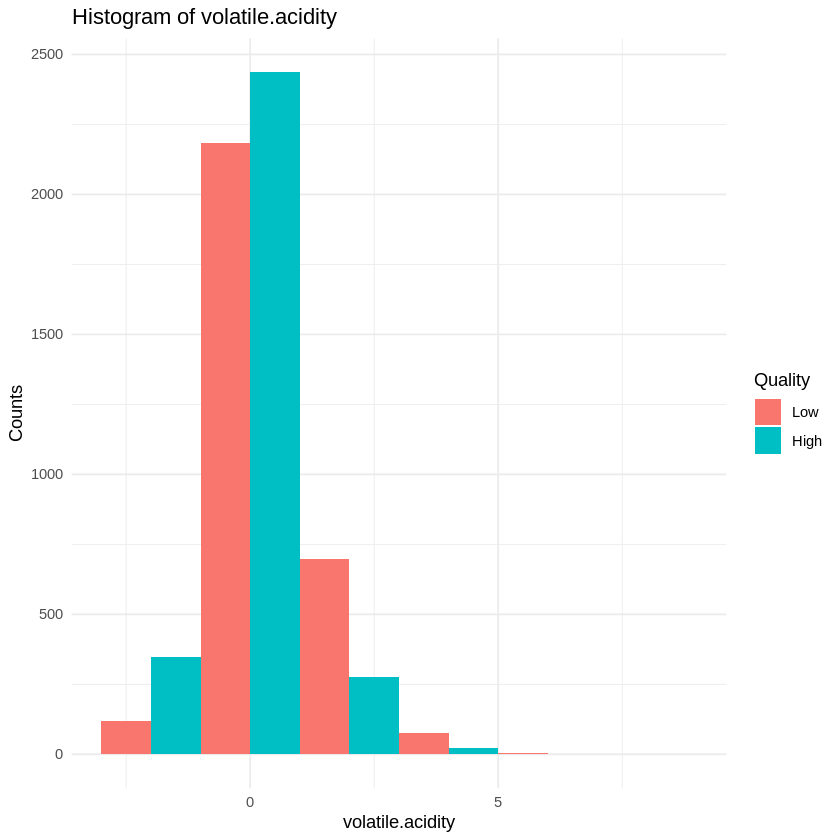

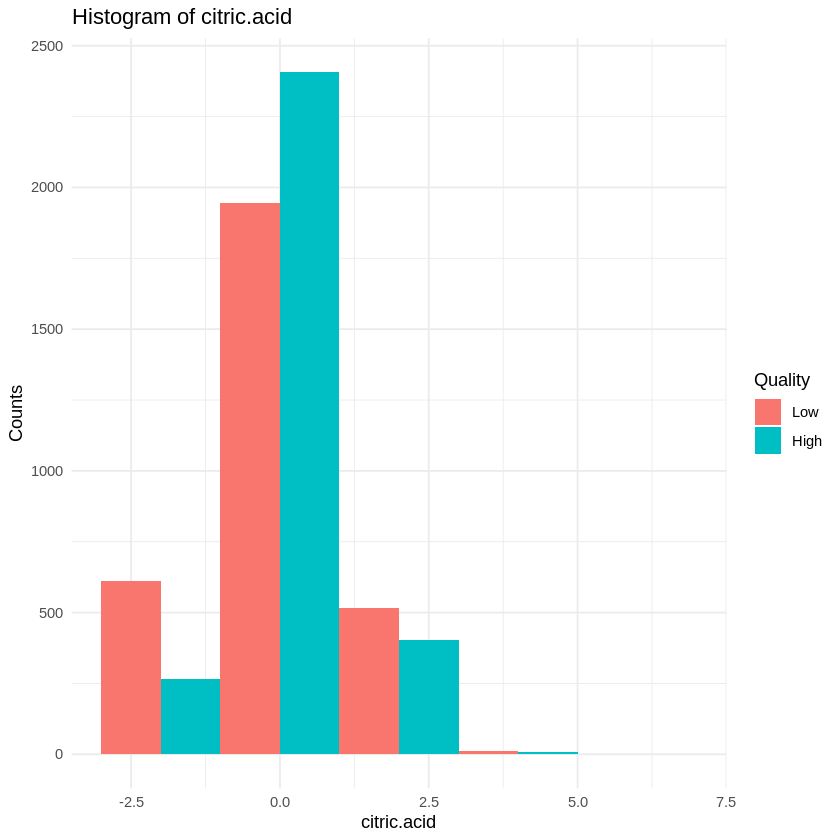

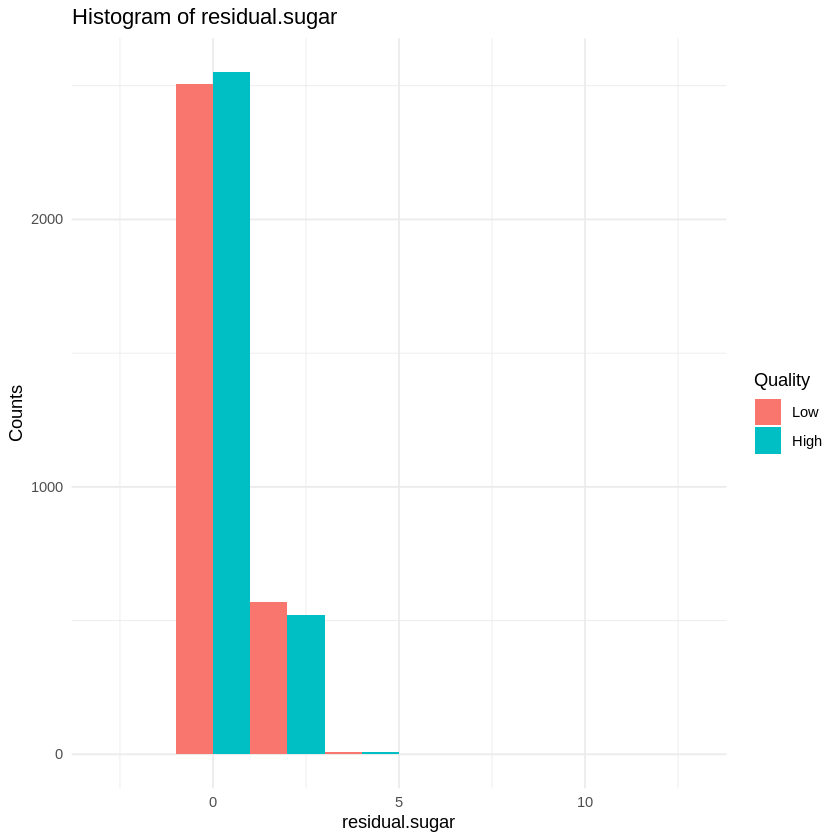

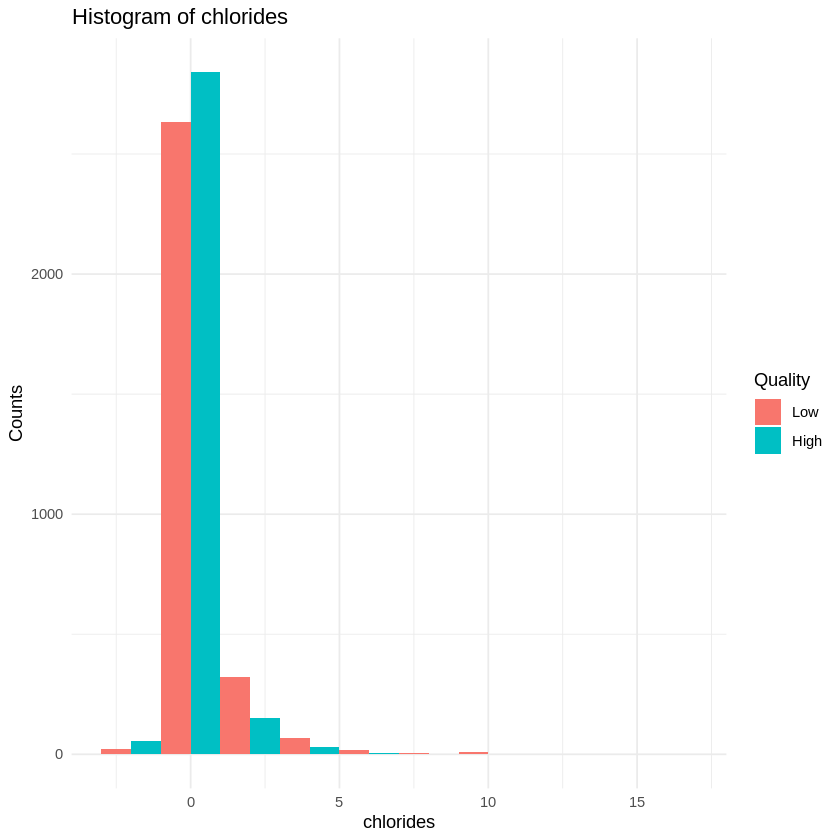

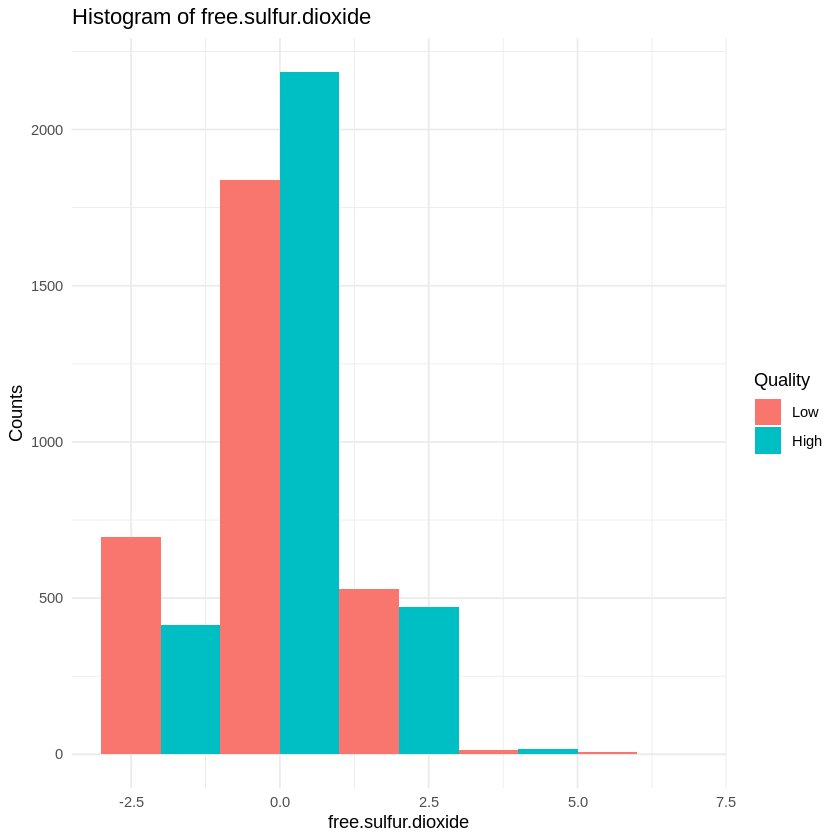

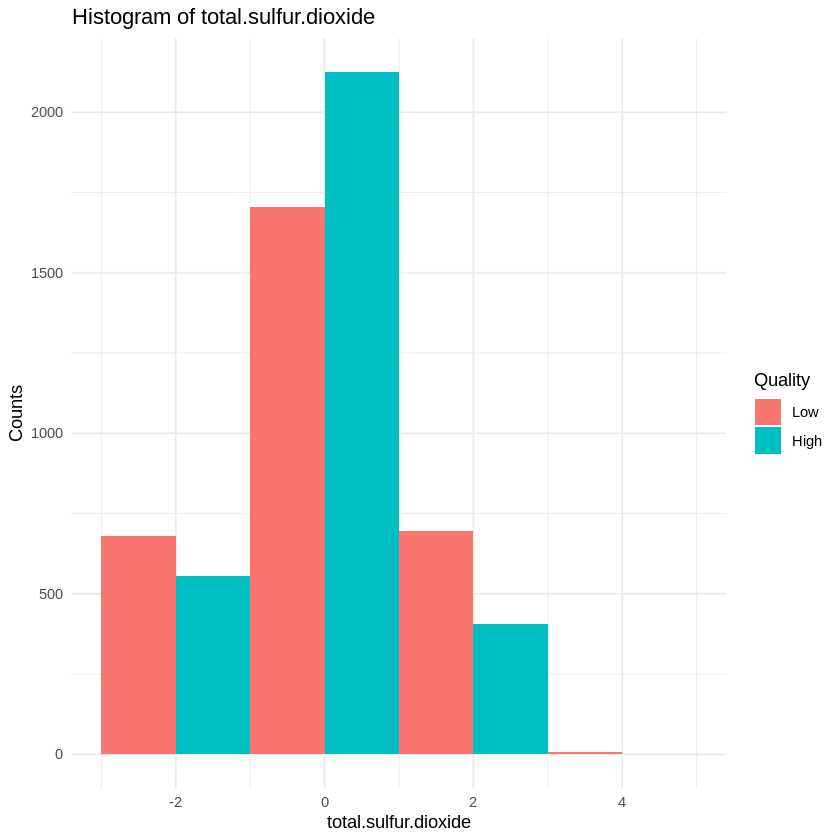

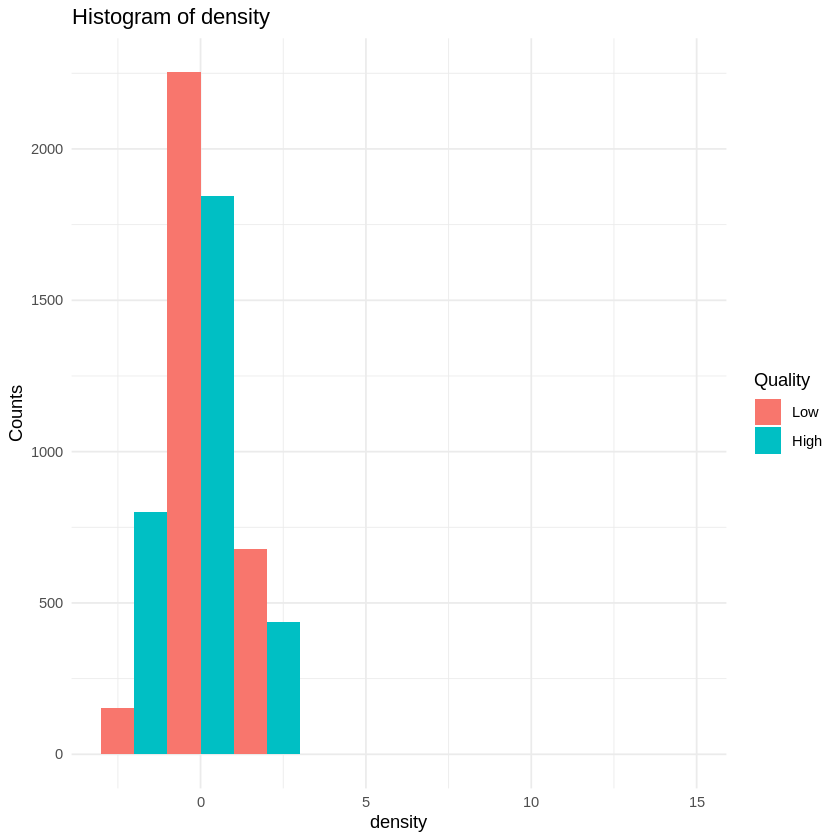

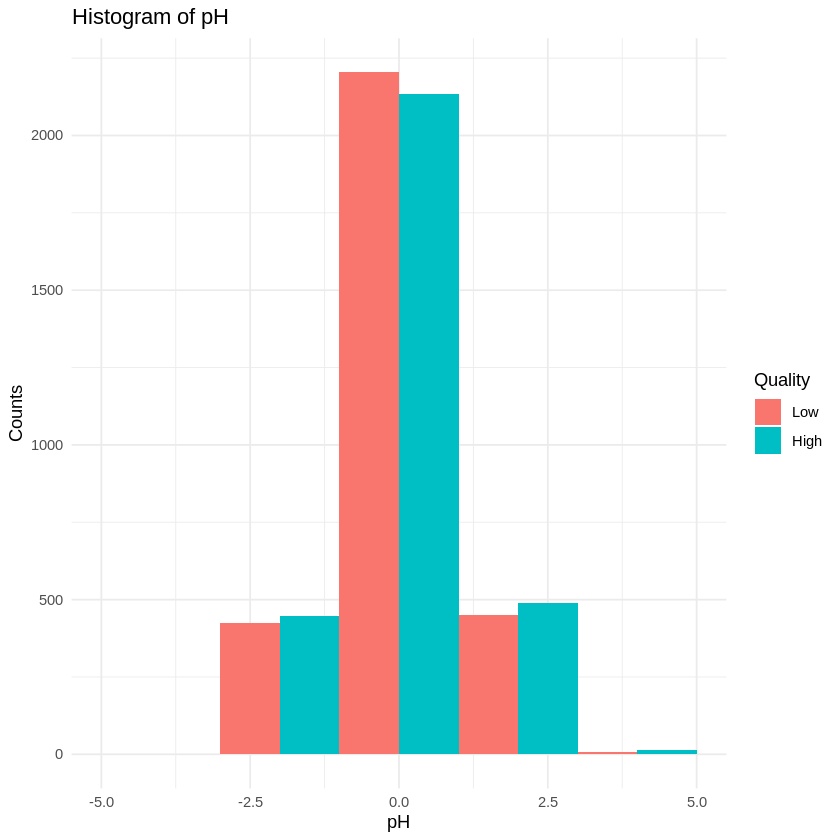

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


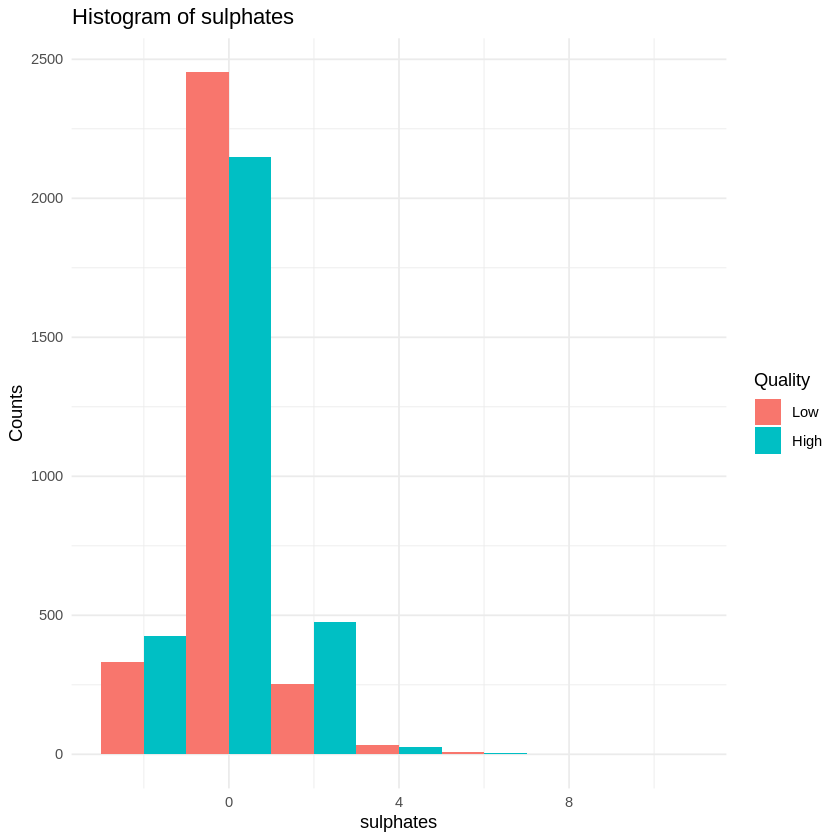

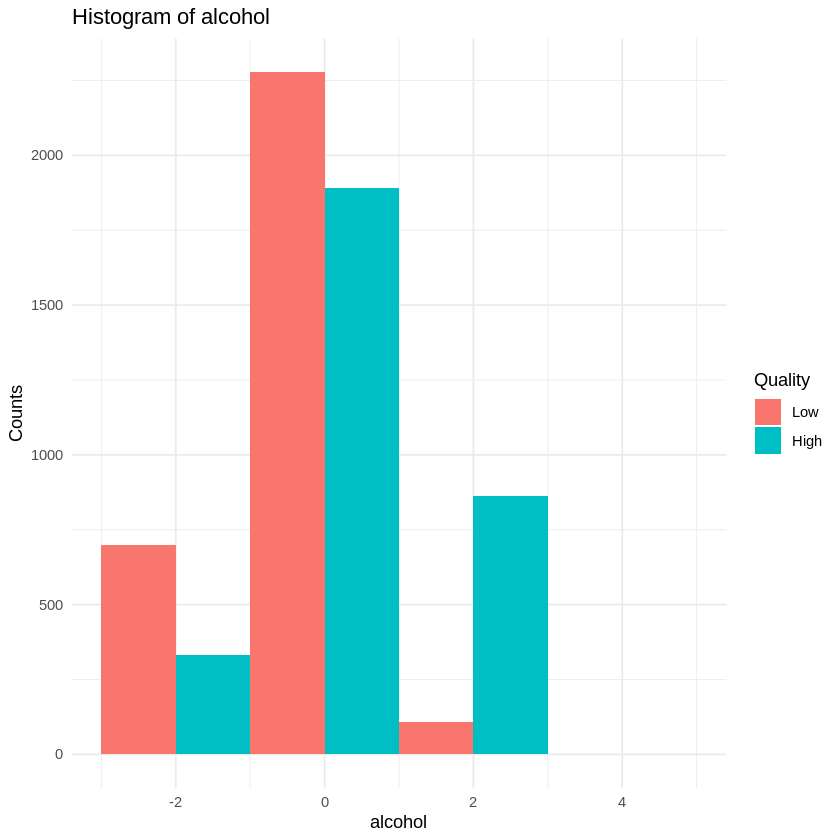

In [15]:
wine_filter <- scaled_wine

histograms <- lapply(names(wine_filter)[!names(wine_filter) %in% c("quality")], function(col) {
  ggplot(wine_filter, aes(x = !!sym(col), fill = quality)) +
    geom_histogram(position = "dodge", bins = 100, binwidth = 2) +
    labs(title = paste("Histogram of", col), x = col, y = "Counts", fill = "Quality") +
    theme_minimal()
})

histograms

- Most variables have a linear negative correlation to quality
- free.sulfur.dioxide and total.sulfur. dioxide seems to have no correlation with quality as the categories' bins are layered in the histogram.
- alcohol and residual.sugar have a non-linear relationship with quality

## Trainning & Evaluation

### 1. The multivariable Linear regression Model

In [ ]:
set.seed(1)
wine_data_reg <- wine_data |>
    mutate(quality = as.numeric(quality)) |>
    select(fixed.acidity, volatile.acidity, citric.acid, chlorides, density, pH, sulphates, quality)
head(wine_data_reg)

recipe <- recipe(quality ~ .,
                 data = wine_data_reg) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()
recipe

wine_scaled_reg <- bake(recipe, wine_data_reg)
wine_scaled_reg

wine_reg_split <- initial_split(wine_scaled_reg, prop = 0.75, strata = quality)
wine_reg_training <- training(wine_reg_split)
wine_reg_testing <- testing(wine_reg_split)

lm_recipe <- recipe(quality ~ .,
                    data = wine_reg_training)
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = wine_reg_training)

lm_fit

lm_test_results <- lm_fit |>
  predict(wine_reg_testing) |>
  bind_cols(wine_reg_testing) |>
  metrics(truth = quality, estimate = .pred)

lm_test_results

lm_coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()
lm_coeffs

The mathematical expression to describe this linear regression model is:
$quality = 3.81501672 + 0.08707008 \cdot (fixed.acidity) - 0.18996941 \cdot (volatile.acidity) + 0.01716328 \cdot (citric.acid) - 0.09945725 \cdot (chlorides) - 0.25886222 \cdot (density) + 0.07753980 \cdot (pH) + 0.13857399 \cdot (sulphates)$

### 2. Classification Model

In [49]:
wine_data_class <- wine_data |>
    select(fixed.acidity, volatile.acidity, citric.acid, chlorides, density, pH, sulphates, quality)

wine_data_class$quality <- as.factor(wine_data_class$quality)

In [50]:
set.seed(1)
wine_class_split <- initial_split(wine_data_class, prop = 0.75, strata = quality)
wine_class_training <- training(wine_class_split)
wine_class_testing <- testing(wine_class_split)

knn_recipe <- recipe(quality ~ ., data = wine_class_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

knn_res <- tune_grid(
    knn_workflow,
    resamples = vfold_cv(wine_class_training, v = 5),
    grid = data.frame(neighbors = seq(1, 50, 5))
)

best_k <- knn_res |>
    select_best("accuracy")

knn_final <- finalize_workflow(knn_workflow, best_k)

knn_fit <- fit(knn_final, data = wine_class_training)

knn_pred <- predict(knn_fit, new_data = wine_class_testing) |>
    bind_cols(wine_class_testing)

accuracy(knn_pred, truth = quality, estimate = .pred_class)

knn_pred_num <- knn_pred |>
    mutate(quality_num = as.numeric(quality),
            .pred_class_num = as.numeric(.pred_class))

knn_rmse <- rmse(knn_pred_num, truth = quality_num, estimate = .pred_class_num)

knn_rmse

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7643077


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.4854815


In [33]:
wine_cl <- wine_data |>
    select(alcohol, density, volatile.acidity, quality)
head(wine_cl)

,alcohol,density,volatile.acidity,quality
,<dbl>,<dbl>,<dbl>,<fct>
1,9.4,0.9978,0.70,Low
2,9.8,0.9968,0.88,Low
3,9.8,0.9970,0.76,Low
4,9.8,0.9980,0.28,High
5,9.4,0.9978,0.70,Low
6,9.4,0.9978,0.66,Low


In [34]:
wine_split <- initial_split(wine_cl, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

In [35]:
wine_recipe <- recipe(quality ~ ., data = wine_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(wine_recipe) |>
  add_model(knn_spec) |>
  fit(data = wine_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2699097
Best kernel: rectangular
Best k: 10

Now we tune the classifier

In [36]:
# create the 25/75 split of the training data into training and validation
wine_split <- initial_split(wine_train, prop = 0.75, strata = quality)
wine_subtrain <- training(wine_split)
wine_validation <- testing(wine_split)

# recreate the standardization recipe from before
# (since it must be based on the training data)
wine_recipe <- recipe(quality ~.,
                        data = wine_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(wine_recipe) |>
  add_model(knn_spec) |>
  fit(data = wine_subtrain)

# get predictions on the validation data
validation_predicted <- predict(knn_fit, wine_validation) |>
  bind_cols(wine_validation)

# compute the accuracy
acc <- validation_predicted |>
  metrics(truth = quality, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

[1] 0.7249589

- The accuracy using this split is 0.725

In [39]:
wine_vfold <- vfold_cv(wine_train, v = 10, strata = quality)

vfold_metrics <- workflow() |>
                  add_recipe(wine_recipe) |>
                  add_model(knn_spec) |>
                  fit_resamples(resamples = wine_vfold) |>
                  collect_metrics()

vfold_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7341986,10,0.006736282,Preprocessor1_Model1
roc_auc,binary,0.7762158,10,0.006895069,Preprocessor1_Model1


- When we use 10 folds, the mean sccuracy is 0.734.

In [40]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [42]:
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 5))

knn_results <- workflow() |>
  add_recipe(wine_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = wine_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7358362,10,0.009211575,Preprocessor1_Model01
6,accuracy,binary,0.7183980,10,0.008636860,Preprocessor1_Model02
11,accuracy,binary,0.7350098,10,0.007829001,Preprocessor1_Model03
16,accuracy,binary,0.7391217,10,0.008142497,Preprocessor1_Model04
21,accuracy,binary,0.7399350,10,0.006961124,Preprocessor1_Model05
26,accuracy,binary,0.7405481,10,0.008481472,Preprocessor1_Model06
31,accuracy,binary,0.7405565,10,0.008004798,Preprocessor1_Model07
36,accuracy,binary,0.7389138,10,0.007738189,Preprocessor1_Model08
41,accuracy,binary,0.7395323,10,0.007379356,Preprocessor1_Model09


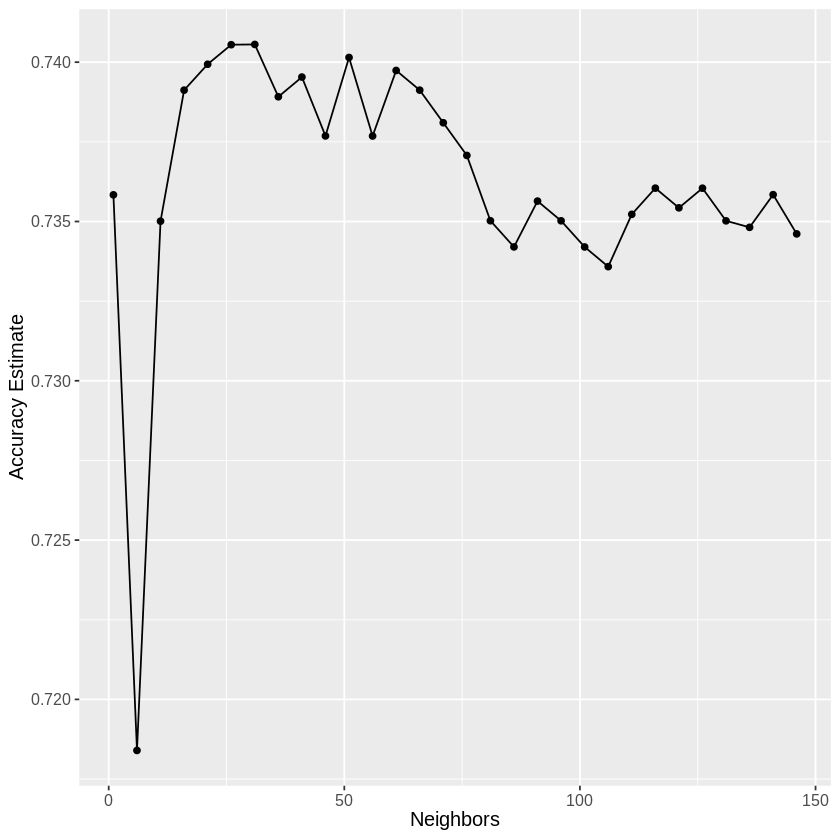

In [43]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [44]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 31

- According to this, we are going to use K = 31 to perform best classification.

In [46]:
knn_recipe <- recipe(quality ~., data = wine_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = wine_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(31,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2588259
Best kernel: rectangular
Best k: 31

In [47]:
wine_test_pred <- predict(knn_fit, wine_test) |>
  bind_cols(wine_test)

wine_test_pred |>
  metrics(truth = quality, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7698462


In [48]:
confusion <- wine_test_pred |>
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction Low High
      Low  377  155
      High 219  874

## Methods

- After data reading and wrangling, we used all 12 variables for preliminary data summarization and visualization. We then compared the number of observations in each red/ white wine class, the number of observations in each quality level for red and white wine respectively, and the mean value of each feature for each quality level. 

- Multi-histogram is used to visualize the relationship between each variable and the wine quality, each with one predictor on the x axis, counts on the y axis, and color indicating the different quality levels. If each quality level tends to show up on a certain value of the x axis, we can conclude that there is linear correlation between the wine quality and that predictor. Otherwise, there is no correlation or non-linear correlation. 

- **We will only use 7 numeric variables excluding type total.sulfur.dioxide, free.sulfur.dioxide, residual sugar and alcohol** 

## Expected outcomes and significance

- Due to class imbalance in the categories of the target column (quality): some of the categories are missing. We expect the model will be less precise for the level from 0 to 2 and the level 10.
- However, we hope the model will be able to predict correctly the quality from 3 - 8

- These findings will allow a more efficient and more systematic wine quality assessment as we will be able assess the quality of the wines not only by its age or individual tastes, but also the actual content in the wine itself.
-  The findings can also lead to further discoveries such as how different environments in which the grapes grew in would affect the quality of the wines, in which they can be used to optimize the wine development.
